In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
# Set up Neural Network

class Net(nn.Module):
    def __init__(self):
        inputDim = 2
        hiddenWidth = 5
        outputDim = 1
    
        super(Net, self).__init__()
        self.fc1 = nn.Linear(inputDim, hiddenWidth)
        self.fc2 = nn.Linear(hiddenWidth, hiddenWidth)
        self.fc3 = nn.Linear(hiddenWidth, hiddenWidth)
        self.fc_out = nn.Linear(hiddenWidth, outputDim)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.fc1(x)
        # activation function 
        x = torch.tanh(x)
        # for monte carlo samples, dropout rate is not necessary
        #x = self.dropout(x)
        
        x = self.fc2(x)
        x = torch.tanh(x)
        #x = self.dropout(x)
        
        x = self.fc3(x)
        x = torch.tanh(x)
        #x = self.dropout(x)
    
        x = self.fc_out(x)
        return x

In [63]:
# Set parameters of the model

# Set time_steps 
T = 1
N = 100
dt = float(T) / N
t_array = np.linspace(0,T,N+1)

# parameters
b = 0.0007
sigma = 0.1
k = 0.0007
A = 0.01
phi = 0.007 

batch_size = 64

In [64]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [65]:
# paths:  torch.Tensor of shape (batch_size, N+1, dim)
net = Net()
net = net.to(device=try_gpu())
print_every_n_steps = 1000

dim = 1
objective = []
learning_steps = 80000

# Adam, lr = 0.0005
optimizer = optim.Adam(net.parameters(),lr=0.0005)

for it in range(learning_steps):
    
    optimizer.zero_grad()
    # Initialize 
    ones = torch.ones(batch_size, 1, dim, device=try_gpu()) # (batch_size, length of path, dim)
    Q = ones * 1 # tensor with shape (batch_size, 1, dim)
    S = ones * 20
    X = ones * 0
    
    # path 
    for id_t, t in enumerate(t_array):
        # Euler scheme
        dW = torch.randn(batch_size, dim,device=try_gpu()) * np.sqrt(dt) # tensor with shape (batch_size, dim)
        tt = torch.ones(batch_size, 1,device=try_gpu()) * t
        inputs = torch.cat((tt, Q[:,-1,:]), 1) # tensor with shape (batch_size, 2)
        v_t = net(inputs)
        
        Q_new = Q[:,-1,:] - v_t * dt # Q_new has shape (batch_size, dim)
        S_new = S[:,-1,:] - b * v_t * dt + sigma * dW
        X_new = X[:,-1,:] + v_t * (S[:,-1,:] - k * v_t) * dt
        
        Q = torch.cat((Q, Q_new.unsqueeze(1)), 1) #shape (batch_size, 1, dim)
        S = torch.cat((S, S_new.unsqueeze(1)), 1)
        X = torch.cat((X, X_new.unsqueeze(1)), 1)
        
    J = 0
    for item in range(batch_size):
        J += X[item,-1,:] + Q[item,-1,:]*S[item,-1,:] - A*Q[item,-1,:]**2 - phi*torch.sum(Q[item,:-1,0]**2*dt)
    J =  - J / batch_size
    
    objective.append(-J.item())
    # update theta
    J.backward()
    optimizer.step()
    
    if it % print_every_n_steps == 0:
        print('step = ', it, ' loss = ', J)

step =  0  loss =  tensor([-19.9869], grad_fn=<DivBackward0>)
step =  1000  loss =  tensor([-19.9904], grad_fn=<DivBackward0>)
step =  2000  loss =  tensor([-19.9939], grad_fn=<DivBackward0>)
step =  3000  loss =  tensor([-19.9882], grad_fn=<DivBackward0>)
step =  4000  loss =  tensor([-19.9952], grad_fn=<DivBackward0>)
step =  5000  loss =  tensor([-19.9991], grad_fn=<DivBackward0>)
step =  6000  loss =  tensor([-19.9907], grad_fn=<DivBackward0>)
step =  7000  loss =  tensor([-19.9911], grad_fn=<DivBackward0>)
step =  8000  loss =  tensor([-19.9954], grad_fn=<DivBackward0>)
step =  9000  loss =  tensor([-20.0013], grad_fn=<DivBackward0>)
step =  10000  loss =  tensor([-19.9950], grad_fn=<DivBackward0>)
step =  11000  loss =  tensor([-19.9967], grad_fn=<DivBackward0>)
step =  12000  loss =  tensor([-20.0007], grad_fn=<DivBackward0>)
step =  13000  loss =  tensor([-19.9965], grad_fn=<DivBackward0>)
step =  14000  loss =  tensor([-19.9968], grad_fn=<DivBackward0>)
step =  15000  loss =  

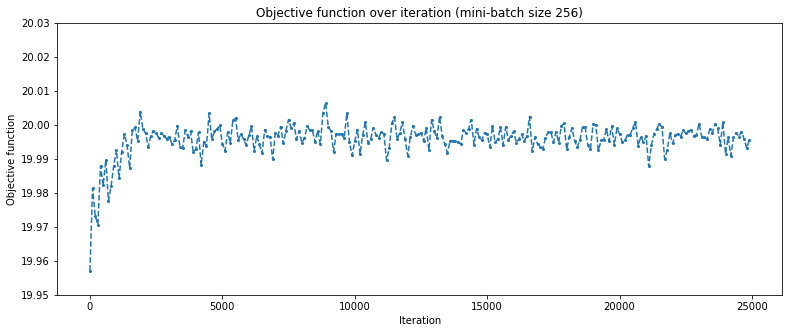

In [60]:
# Plot the objective function over iterations

objective_function = [objective[i] for i in range(0,learning_steps,100)] # plot every 100 steps
x = [i for i in range(0,learning_steps,100)]

fig,ax = plt.subplots(figsize=(13,5))
ax.plot(x,objective_function,"o--",markersize=2)
ax.set_title("Objective function over iteration (mini-batch size 256)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective function")

plt.ylim(19.95,20.03)
plt.show()
#fig.savefig('minibatch256.jpg')    

In [74]:
# Use the trained neural networks to calculate optimal controls/ inventory / cash processes

ones = torch.ones(batch_size, 1, dim) # (batch_size, length of path, dim)
Q = ones * 1 # tensor with shape (batch_size, 1, dim)
S = ones * 20
X = ones * 0
v = []
    
for id_t, t in enumerate(t_array):
    # Euler scheme
    dW = torch.randn(batch_size, dim,device=try_gpu()) * np.sqrt(dt)
    tt = torch.ones(batch_size, 1) * t
    inputs = torch.cat((tt, Q[:,-1,:]), 1) # tensor with shape (batch_size, 2)
    v_t = net(inputs)
    v.append(v_t)
        
    Q_new = Q[:,-1,:] - v_t * dt # Q_new has shape (batch_size, dim)
    S_new = S[:,-1,:] - b * v_t * dt + sigma * dW
    X_new = X[:,-1,:] + v_t * (S[:,-1,:] - k * v_t) * dt
        
    Q = torch.cat((Q, Q_new.unsqueeze(1)), 1)
    S = torch.cat((S, S_new.unsqueeze(1)), 1)
    X = torch.cat((X, X_new.unsqueeze(1)), 1)
    
    
control = np.zeros([batch_size,len(t_array)])
for i in range(len(t_array)):
    control[:,i] = v[i].detach().numpy()[:,0]
    

inventory = Q[:,:-1,:].detach().numpy()
cash = X[:,:-1,:].detach().numpy()

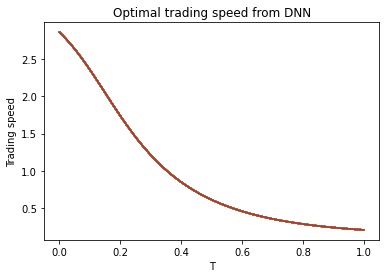

In [76]:
# Plot the learned controls

fig,ax = plt.subplots()
for i in range(batch_size):
    ax.plot(t_array,control[i,:])
    
ax.set_title("Optimal trading speed from DNN")
ax.set_xlabel("T")
ax.set_ylabel("Trading speed")
plt.show()

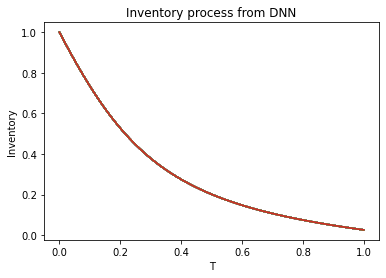

In [78]:
# Plot the corresponding inventory process

fig,ax = plt.subplots()

for i in range(batch_size):
    ax.plot(t_array,inventory[i,:,0])
    
ax.set_title("Inventory process from DNN")
ax.set_xlabel("T")
ax.set_ylabel("Inventory")
plt.show()

#fig.savefig('change_alpha_trading.jpg')  

In [ ]:
# Plot the corresponding cash process
fig,ax = plt.subplots()

for i in range(batch_size):
    plt.plot(t_array,cash[i,:,0])
    
ax.set_title("Cash process from DNN")
ax.set_xlabel("T")
ax.set_ylabel("Revenue")
plt.show()

In [79]:
# analytical solution of the optimal control

gamma = np.sqrt(phi / k)
epsilon = (A-0.5*b+np.sqrt(k*phi)) / (A-0.5*b-np.sqrt(k*phi))

analytical_v = np.zeros([batch_size, len(t_array)-1])
analytical_q = np.zeros([batch_size,len(t_array)])
analytical_S = np.zeros([batch_size,len(t_array)])
analytical_X = np.zeros([batch_size,len(t_array)])
analytical_dW = np.sqrt(dt)*np.random.randn(batch_size,len(t_array)-1)

analytical_q[:,0] = 1
analytical_S[:,0] = 20
analytical_X[:,0] = 0

for i in range(len(t_array)-1):
    t = i*dt
    analytical_v[:,i] = analytical_q[:,i]*gamma*(epsilon*np.exp(gamma*(T-t))+np.exp(-gamma*(T-t))) / (epsilon*np.exp(gamma*(T-t))-np.exp(-gamma*(T-t)))
    analytical_q[:,i+1] = analytical_q[:,i] - analytical_v[:,i]*dt
    analytical_S[:,i+1] = analytical_S[:,i] - b*analytical_v[:,i]*dt + sigma*analytical_dW[:,i]
    analytical_X[:,i+1] = analytical_X[:,i] + (analytical_S[:,i]-k*analytical_v[:,i])*analytical_v[:,i]*dt

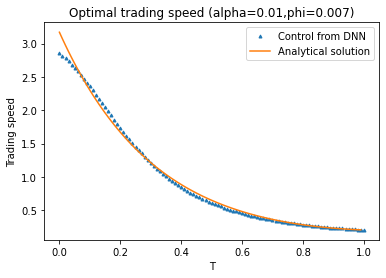

In [87]:
# compare learned control with  analytical solution  

fig,ax = plt.subplots()

ax.plot(t_array,control[0,:],"^",markersize=3, label="Control from DNN")
ax.plot(t_array[:-1],analytical_v[0],label="Analytical solution")

ax.set_title("Optimal trading speed (alpha=0.01,phi=0.007)")
ax.set_xlabel("T")
ax.set_ylabel("Trading speed")
plt.legend()
#fig.savefig('bk00005.jpg')
plt.show()

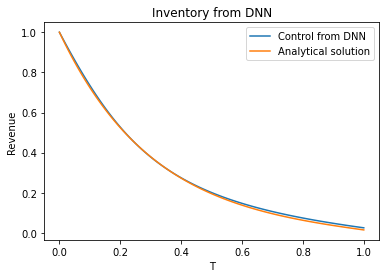

In [72]:
# compare the inventory processes 

fig,ax = plt.subplots()

ax.plot(t_array,inventory[0,:,0],label="Control from DNN")
ax.plot(t_array,analytical_q[0],label="Analytical solution")
    
ax.set_title("Inventory from DNN")
ax.set_xlabel("T")
ax.set_ylabel("Revenue")
plt.legend()
plt.show() 